# EDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
os.getcwd()

'/home/bon/CV_project/Classification/Loan-default-prediction'

In [3]:
os.listdir('data')

['.ipynb_checkpoints', 'predict_data.csv', 'train.csv']

In [4]:
all_data = pd.read_csv('data/train.csv')

- Cat_features: label encode
- city: maybe cardinality handler

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


## All features profiling

In [6]:
#Importing the function
from pandas_profiling import ProfileReport
#Generate the report. We would use the mpg dataset as sample, title parameter for naming our report, and explorative parameter set to True for Deeper exploration.
profile = ProfileReport(all_data, title='Profiling Report', explorative = True)
profile

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Compare feature distribution of the two classes

In [6]:
# Since the field `enrollee_id` is 100% distinct and have no missing, it can be used as index
all_data.set_index('Id', inplace = True)

In [7]:
cat_features = []
num_features = []

data_types = all_data.drop('Risk_Flag', axis = 1).dtypes
for feature in data_types.index:
    if data_types[feature] == 'object':
        cat_features.append(feature)
    else:
        num_features.append(feature)

In [8]:
cat_features

['Married/Single',
 'House_Ownership',
 'Car_Ownership',
 'Profession',
 'CITY',
 'STATE']

In [9]:
num_features

['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

In [10]:
import matplotlib.pyplot as plt

### Numerical features distribution

- Each numerical features of each class will be visualized in a histogram
- Since the number of classes are imbalanced, the distributions are percentage instead of absolute count

In [11]:
eda_data = {
    'defaulted': all_data[all_data['Risk_Flag'] == 1],
    'not_defaulted': all_data[all_data['Risk_Flag'] == 0]
}
weights = dict()
for class_ in eda_data:
    weights[class_] = len(eda_data[class_].index)
    weights[class_] = np.ones(weights[class_]) / weights[class_]

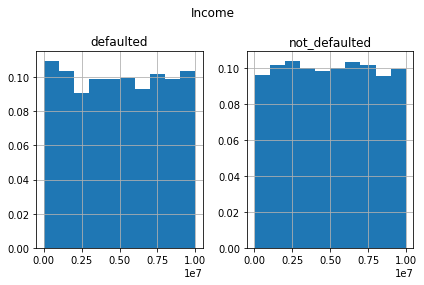

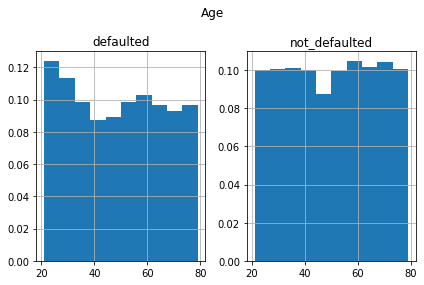

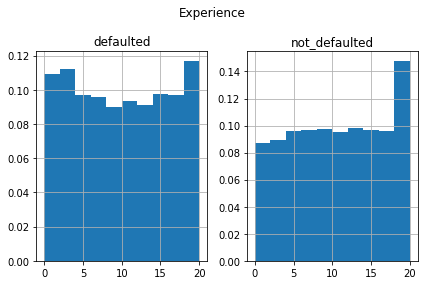

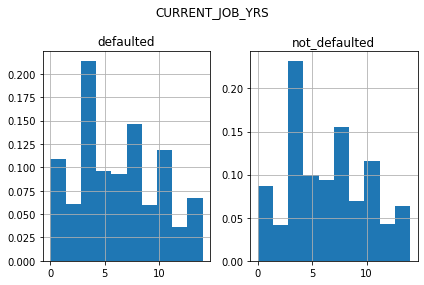

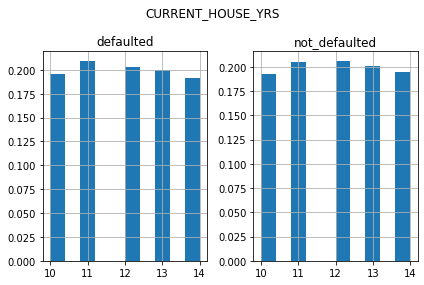

In [12]:
for col in num_features:
    fig, ax = plt.subplots(1, 2)
    idx = 0
    for class_ in eda_data:
        eda_data[class_][col].hist(ax = ax[idx], weights = weights[class_])
        ax[idx].set_title(class_)
        idx += 1
    fig.suptitle(col)
    plt.tight_layout()
    plt.show()

<b>Striking point(s):</b>
- The distributions of the numerical features of both classes very similar
- The `not_defaulted` users' `Experience` has a higher percentage of worker with 20 years experience

### Categorical features (top up to 10 values)

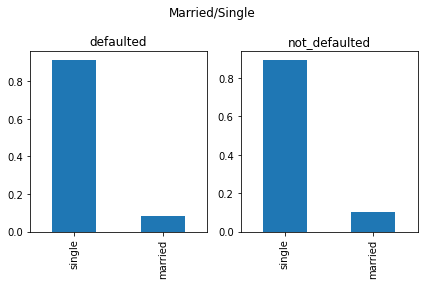

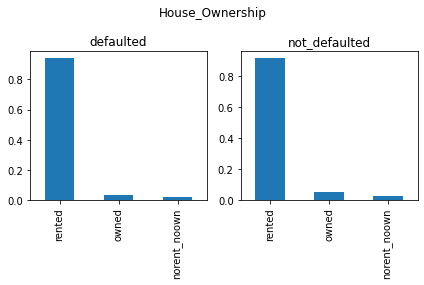

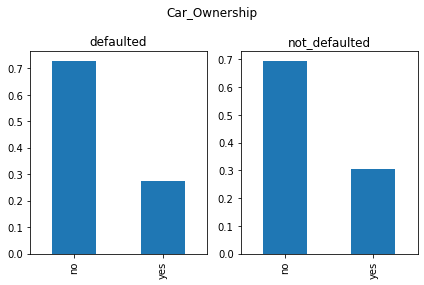

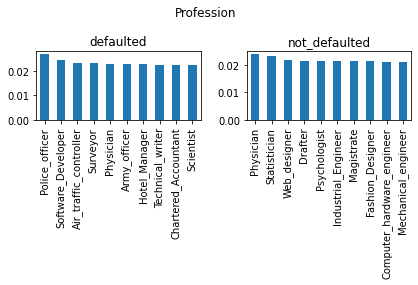

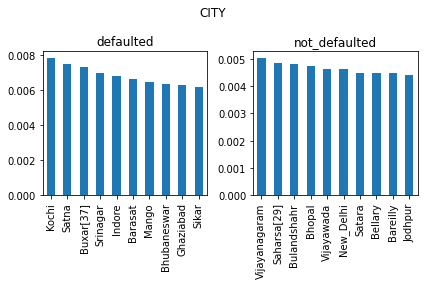

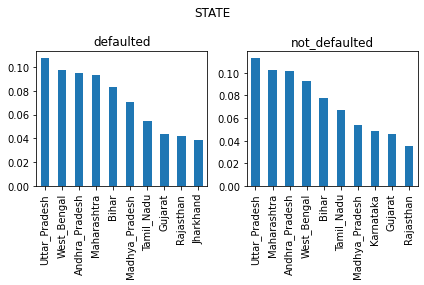

In [13]:
for col in cat_features:
    fig, ax = plt.subplots(1, 2)
    idx = 0
    for class_ in eda_data:
        eda_data[class_][col].value_counts(normalize = True)[:10].plot.bar(ax = ax[idx])
        ax[idx].set_title(class_)
        idx += 1
    fig.suptitle(col)
    plt.tight_layout()
    plt.show()

<b>Striking point(s):</b>
- The top `Profession`, `STATE` and `CITY` of the two classes are very different

# Model

## Estimator

In [14]:
from catboost import CatBoostClassifier

In [15]:
class CustomizedCatBoostClassifier(CatBoostClassifier):
    def fit(self, X, y, *args, **kwargs):
        X_train, X_eval, y_train, y_eval = train_test_split(X, 
                                                            y, 
                                                            test_size = 0.3)
        
        super().fit(
            X_train,
            y_train,
            eval_set = (X_eval, y_eval),
            *args,
            **kwargs
        )
        
        return self

## Preprocessor

Since some features has very high cardinality (e.g. `CITY` has more than `300` values), a `CardinalityHandler` which restricts the cardinality is useful to speed the training up

In [16]:
from sklearn import set_config
set_config(display='diagram')

In [17]:
from sklearn.base import TransformerMixin, BaseEstimator

class CardinalityHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns, cardinality):
        if len(columns) != len(cardinality):
            raise Exception("The len of the list of columns does not match the len of the cardinality")
            
        self.columns = columns
        self.cardinality = cardinality
        self.top_values = dict()
    
    def fit(self, X, y = None):
        for i in range(len(self.columns)):
            self.top_values[self.columns[i]] = list(X[self.columns[i]].value_counts().index)[:self.cardinality[i]]
            if 'unk' not in self.top_values[self.columns[i]]:
                self.top_values[self.columns[i]].append('unk')
            
            if 'capped_value' not in self.top_values[self.columns[i]]:
                self.top_values[self.columns[i]].append('capped_value')
                
        return self
    
    def transform(self, X, y = None, copy = False):
        if copy:
            tranform_data = X.copy()
        else:
            transform_data = X
        
        for col, top_val in self.top_values.items():
            transform_data.loc[:, col] = transform_data[col].apply(lambda x: x if x in top_val else 'capped_value')
            
        return transform_data

In [18]:
from sklearn.impute import SimpleImputer

class CustomizedSimpleImputer(SimpleImputer):
    def transform(self, X):
        data = super().transform(X)
        return pd.DataFrame(data, columns = X.columns, index = X.index)

In [19]:
from sklearn.compose import ColumnTransformer

class CustomizedColumnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        return pd.concat(Xs, axis = 1)

In [20]:
from sklearn.pipeline import FeatureUnion, Pipeline
class CustomizedFeatureUninon(FeatureUnion):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        cols = np.hstack(cols)
        return pd.DataFrame(super()._hstack(Xs), columns = cols)

In [21]:
cat_imputer = CustomizedSimpleImputer(
    missing_values = np.nan,
    strategy = 'constant',
    fill_value = 'unk', # short for unknown
)
columns = ['CITY']
cardinality = [100]
cardinality_handler =  CardinalityHandler(columns, cardinality)

cat_handler = Pipeline(steps = [
    ('imputer', cat_imputer),
    ('cardinalityHandler', cardinality_handler)
],
                      verbose = False)

num_imputer = CustomizedSimpleImputer(
    missing_values = np.nan,
    strategy = 'most_frequent',
)

preprocessor = CustomizedColumnTransformer([
    ('catHandler', cat_handler, cat_features),
    ('numHandler', num_imputer, num_features)
],
n_jobs = -1)

In [22]:
fu = CustomizedFeatureUninon([
    ('featureUnion', preprocessor)
])

In [23]:
pl = Pipeline(steps = [
    ('preprocessor', fu),
    ('estimator', CustomizedCatBoostClassifier(cat_features = cat_features,
                                               use_best_model = True,
                                               verbose = True,
                                               metric_period = 100,
                                               early_stopping_rounds = 25,
                                               auto_class_weights = 'Balanced'
                                              ))
],
             verbose = True)

In [24]:
pl

Pipeline(steps=[('preprocessor',
                 CustomizedFeatureUninon(transformer_list=[('featureUnion',
                                                            CustomizedColumnTransformer(n_jobs=-1,
                                                                                        transformers=[('catHandler',
                                                                                                       Pipeline(steps=[('imputer',
                                                                                                                        CustomizedSimpleImputer(fill_value='unk',
                                                                                                                                                strategy='constant')),
                                                                                                                       ('cardinalityHandler',
                                                                                                                        CardinalityHandler(cardinality=[100],
                                                                                                                                           columns=['CITY']))]),
                                                                                                       ['Married/Single',
                                                                                                        'House_Ownership',
                                                                                                        'Car_Ownership',
                                                                                                        'Profession',
                                                                                                        'CITY',
                                                                                                        'STATE']),
                                                                                                      ('numHandler',
                                                                                                       CustomizedSimpleImputer(strategy='most_frequent'),
                                                                                                       ['Income',
                                                                                                        'Age',
                                                                                                        'Experience',
                                                                                                        'CURRENT_JOB_YRS',
                                                                                                        'CURRENT_HOUSE_YRS'])]))])),
                ('estimator',
                 <__main__.CustomizedCatBoostClassifier object at 0x7fcad0f582d0>)],
         verbose=True)

# Training

## Split data

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train_data, test_data = train_test_split(all_data, test_size = 0.2)

In [27]:
train_data.head()

Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
Id                                                                              
126664  8939580   50           3         single          rented           yes   
155291  6467458   68           3         single          rented           yes   
137714  1612818   79          10         single          rented            no   
61239   9345198   49           9         single          rented            no   
206013  1755216   38          15         single          rented            no   

                 Profession        CITY        STATE  CURRENT_JOB_YRS  \
Id                                                                      
126664            Physician  Pallavaram   Tamil_Nadu                3   
155291        Hotel_Manager     Kolkata  West_Bengal                3   
137714               Lawyer     Sonipat      Haryana               10   
61239   Industrial_Engineer       Ajmer    Rajasthan                9   
206013        Hotel_Manager    Haridwar  Uttarakhand               11   

        CURRENT_HOUSE_YRS  Risk_Flag  
Id                                    
126664                 13          0  
155291                 11          0  
137714                 11          1  
61239                  11          1  
206013                 13          0

In [28]:
label = train_data['Risk_Flag'].copy()
train_data = train_data.drop('Risk_Flag', axis = 1)

test_label = test_data['Risk_Flag'].copy()
test_data = test_data.drop('Risk_Flag', axis = 1)

In [29]:
train_data.shape

(201600, 11)

In [30]:
label.value_counts(normalize = True)

0    0.877188
1    0.122813
Name: Risk_Flag, dtype: float64

In [31]:
test_data.shape

(50400, 11)

In [32]:
test_label.value_counts(normalize = True)

0    0.87625
1    0.12375
Name: Risk_Flag, dtype: float64

## Oversampling

The data is extremely unbalanced, therefore, oversampling is necessary

In [33]:
cat_col_loc = []
for col in cat_features:
    cat_col_loc.append(train_data.columns.get_loc(col))

In [34]:
from imblearn.over_sampling import SMOTENC
X_resampled, y_resampled = SMOTENC(categorical_features = cat_col_loc).fit_resample(train_data, label)

## Fit

In [35]:
pl.fit(X_resampled, y_resampled)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.9s
Learning rate set to 0.123639


0:	learn: 0.6534629	test: 0.6512775	best: 0.6512775 (0)	total: 339ms	remaining: 5m 38s
100:	learn: 0.3309327	test: 0.3189771	best: 0.3189771 (100)	total: 12.7s	remaining: 1m 53s
200:	learn: 0.2973286	test: 0.2876865	best: 0.2876865 (200)	total: 24.6s	remaining: 1m 37s
300:	learn: 0.2835773	test: 0.2762819	best: 0.2762819 (300)	total: 36.5s	remaining: 1m 24s
400:	learn: 0.2751304	test: 0.2696833	best: 0.2696833 (400)	total: 50.1s	remaining: 1m 14s
500:	learn: 0.2680790	test: 0.2640844	best: 0.2640844 (500)	total: 1m 2s	remaining: 1m 2s
600:	learn: 0.2629403	test: 0.2602174	best: 0.2602174 (600)	total: 1m 19s	remaining: 52.7s
700:	learn: 0.2591507	test: 0.2575766	best: 0.2575766 (700)	total: 1m 34s	remaining: 40.2s
800:	learn: 0.2554752	test: 0.2552045	best: 0.2552041 (798)	total: 1m 52s	remaining: 27.9s
900:	learn: 0.2513979	test: 0.2525099	best: 0.2525099 (900)	total: 2m 9s	remaining: 14.3s
999:	learn: 0.2478909	test: 0.2500632	best: 0.2500632 (999)	total: 2m 28s	remaining: 0us

bestTe

Pipeline(steps=[('preprocessor',
                 CustomizedFeatureUninon(transformer_list=[('featureUnion',
                                                            CustomizedColumnTransformer(n_jobs=-1,
                                                                                        transformers=[('catHandler',
                                                                                                       Pipeline(steps=[('imputer',
                                                                                                                        CustomizedSimpleImputer(fill_value='unk',
                                                                                                                                                strategy='constant')),
                                                                                                                       ('cardinalityHandler',
                                                                                                                        CardinalityHandler(cardinality=[100],
                                                                                                                                           columns=['CITY']))]),
                                                                                                       ['Married/Single',
                                                                                                        'House_Ownership',
                                                                                                        'Car_Ownership',
                                                                                                        'Profession',
                                                                                                        'CITY',
                                                                                                        'STATE']),
                                                                                                      ('numHandler',
                                                                                                       CustomizedSimpleImputer(strategy='most_frequent'),
                                                                                                       ['Income',
                                                                                                        'Age',
                                                                                                        'Experience',
                                                                                                        'CURRENT_JOB_YRS',
                                                                                                        'CURRENT_HOUSE_YRS'])]))])),
                ('estimator',
                 <__main__.CustomizedCatBoostClassifier object at 0x7fcad0f582d0>)],
         verbose=True)

# Evaluate

In [36]:
y_pred = pl.predict(test_data)

In [37]:
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix

## Classification report

In [38]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     44163
           1       0.51      0.81      0.63      6237

    accuracy                           0.88     50400
   macro avg       0.74      0.85      0.78     50400
weighted avg       0.91      0.88      0.89     50400



## AUC

### Raw ROC_AUC score

In [39]:
roc_auc_score(test_label, y_pred)

0.8491057119207381

### Classes AUC Curve and score

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import cycle

def auc_report(model, X, y_true, fig, ax):
    classes = model.classes_
    y_pred_classes = model.predict_proba(X)
    y_pred = model.predict(X)
    n_classes = len(classes)

    lw = 2
    for i in range(len(classes)):
        print(f"""{classes[i]}: {roc_auc_score(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])}""")

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves

    ax.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    fig.suptitle('Some extension of Receiver operating characteristic to multi-class')
    ax.legend(loc="lower right")
#         plt.show()

    output = {
            'macro_auc': roc_auc["macro"],
#             f'auc_{classes[0]}': roc_auc[0],
#             f'auc_{classes[1]}': roc_auc[1]
    }
    
    for i in range(len(classes)):
        output[f'auc_{classes[i]}'] = roc_auc[i]

    return output

0: 0.9158276804458751
1: 0.9158276804458753


{'macro_auc': 0.9158427292234668,
 'auc_0': 0.9158276804458751,
 'auc_1': 0.9158276804458753}

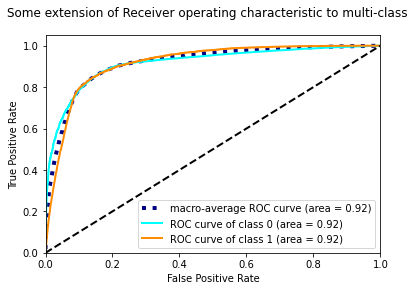

In [41]:
fig, ax = plt.subplots()
# y_pred_classes = pl.predict_proba(test_data.drop('Risk_Flag', axis = 1))
auc_report(pl, test_data, test_label, fig, ax)

## Confusion matrix

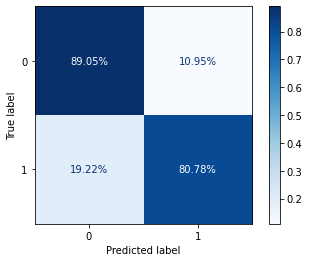

In [42]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, 
                      y_pred, 
                      test_label, 
                      normalize='true', 
                      values_format='.2%',
                      cmap = 'Blues'
                     );

# Model explainability

## Feature importance

In [43]:
fi_df = pd.DataFrame({
    'feature': train_data.columns,
    'feature_importance':pl.steps[-1][1].get_feature_importance()
})

<AxesSubplot:ylabel='feature'>

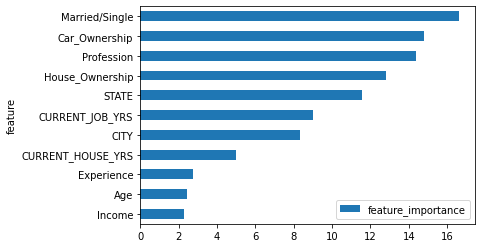

In [44]:
fi_df.set_index('feature').sort_values(by = 'feature_importance').plot.barh()

## Shap value

In [45]:
import shap

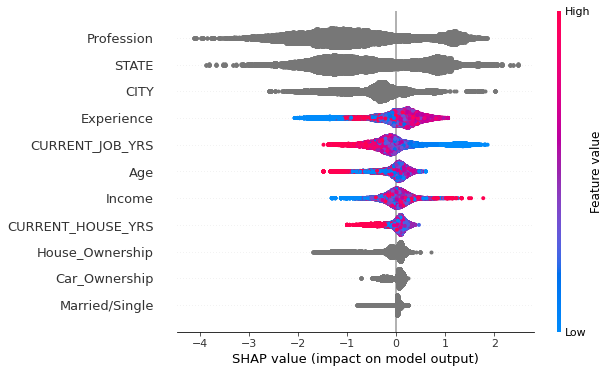

In [46]:
X = pl.steps[0][1].fit_transform(test_data)
shap.initjs()
explainer = shap.TreeExplainer(pl.steps[-1][1])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, 
                  X.to_numpy(),
                  feature_names = X.columns
                 )

<b>Note:</b> The points of categorical features in the graph does not have any color because those features does not have a hierachy (low, high)

### Not Defaulted users

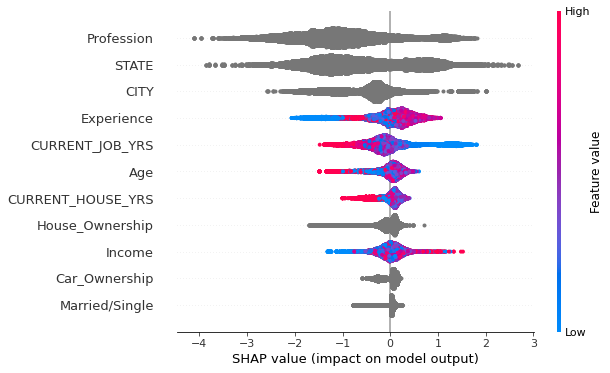

In [47]:
X = pl.steps[0][1].fit_transform(test_data.loc[test_label[test_label == 0].index])
shap.initjs()
explainer = shap.TreeExplainer(pl.steps[-1][1])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, 
                  X.to_numpy(),
                  feature_names = X.columns,
#                   plot_type = 'bar'
                 )

### Defaulted users

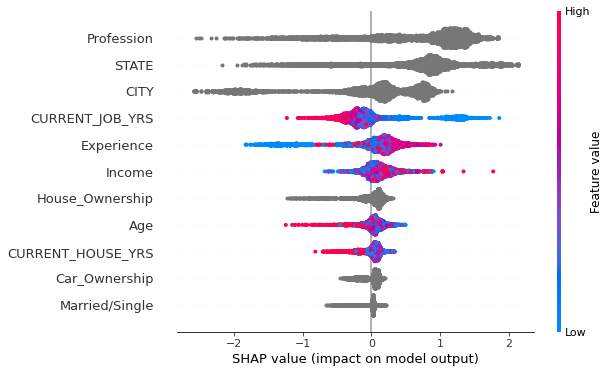

In [48]:
X = pl.steps[0][1].fit_transform(test_data.loc[test_label[test_label == 1].index])
shap.initjs()
explainer = shap.TreeExplainer(pl.steps[-1][1])
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, 
                  X.to_numpy(),
                  feature_names = X.columns,
#                   plot_type = 'bar'
                 )

# Error Analysis

- Investigate the pattern of the wrongly classified users by looking at their top features

In [49]:
ea_df = pd.DataFrame({
    'y_pred': y_pred,
    'y_true': test_label
})

In [50]:
ea_df['true'] = ea_df['y_pred'] == ea_df['y_true']

In [51]:
ea_df = pd.concat([ea_df, test_data], axis = 1)

## Wrongly classified as `Defaulted`

<AxesSubplot:>

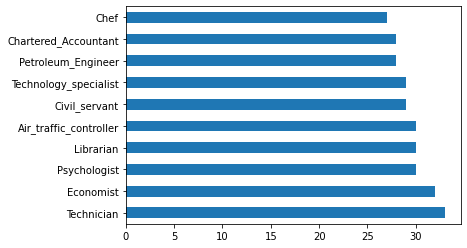

In [52]:
ea_df[(ea_df['true'] == False) & (ea_df['y_true'] == 1)]['Profession'].value_counts()[:10].plot.barh()

In [53]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 1)]['Married/Single'].value_counts()[:10].plot.bar()

<AxesSubplot:>

In [54]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 1)]['CURRENT_JOB_YRS'].hist()

<AxesSubplot:>

<AxesSubplot:>

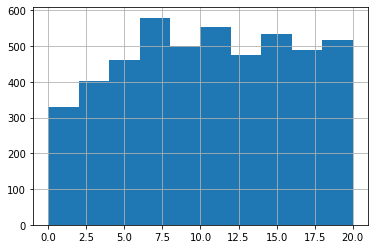

In [55]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 1)]['Experience'].hist()

## Wrongly classified as `Not Defaulted`

<AxesSubplot:>

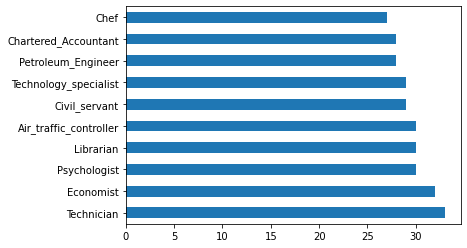

In [56]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 0)]['Profession'].value_counts()[:10].plot.barh()

<AxesSubplot:>

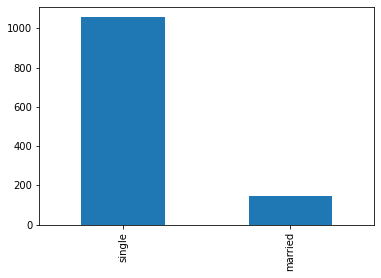

In [57]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 0)]['Married/Single'].value_counts()[:10].plot.bar()

<AxesSubplot:>

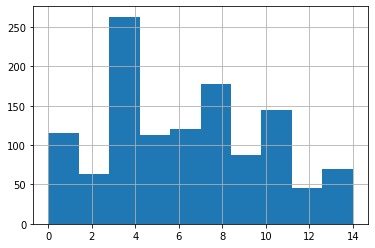

In [58]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 0)]['CURRENT_JOB_YRS'].hist()

In [59]:
ea_df[(ea_df['true'] == False) & (ea_df['y_pred'] == 0)]['Experience'].hist()

<AxesSubplot:>

<b>Striking point(s):</b>
- Most users' `Profession` are not the popular one of neither classes

# Conclusion

- Overall, the model performance is acceptable (ROC_AUC score, accuracy, each class' auc)
- The precision of `defaulted` class is low, but it is acceptable because the number of this class is very small compared to the others. Therefore, a small percentage of wrongly classified users in the `not defaulted` class can lead to a low precision in `defaulted`
- The model explainability and feature importance are reasonable

# What to do next

- Do parameter tuning to improve the performance
- Try different preprocessor (e.g. encode the categorical values to decrease the size of the model)
- Try different tree-based models (LightGBM, XGBoost)

# Predict

In [64]:
predict_data = pd.read_csv('data/predict_data.csv')

In [65]:
predict_data.head()

ID   Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
0   1  7393090   59          19         single          rented            no   
1   2  1215004   25           5         single          rented            no   
2   3  8901342   50          12         single          rented            no   
3   4  1944421   49           9        married          rented           yes   
4   5    13429   25          18         single          rented           yes   

    Profession        CITY        STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  
0    Geologist       Malda  West Bengal                4                 13  
1  Firefighter       Jalna  Maharashtra                5                 10  
2       Lawyer       Thane  Maharashtra                9                 14  
3      Analyst       Latur  Maharashtra                3                 12  
4     Comedian  Berhampore  West Bengal               13                 11

In [66]:
predict_data.set_index('ID', inplace = True)

prediction = pl.predict(predict_data)

In [67]:
prediction

array([0, 0, 0, ..., 0, 0, 1])

In [68]:
predict_data['prediction'] = prediction
predict_data[['prediction']].to_csv('data/prediction.csv')